In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_excel('dataset\Dataset Text.xlsx')

In [4]:
df.head()

,Kalimat,Label,Text
0,R1,supports,competition can effectively promote the develo...
1,R2,attacks,competition can effectively promote the develo...
2,R3,supports,what we acquired from team work is not only ho...
3,R4,supports,through cooperation children can learn about i...
4,R5,supports,all of these skills help them to get on well w...


In [5]:
df = df.drop(['Kalimat'],axis=1)

In [6]:
df.head()

,Label,Text
0,supports,competition can effectively promote the develo...
1,attacks,competition can effectively promote the develo...
2,supports,what we acquired from team work is not only ho...
3,supports,through cooperation children can learn about i...
4,supports,all of these skills help them to get on well w...


Text(0.5, 1.0, 'Label Data Distribution')

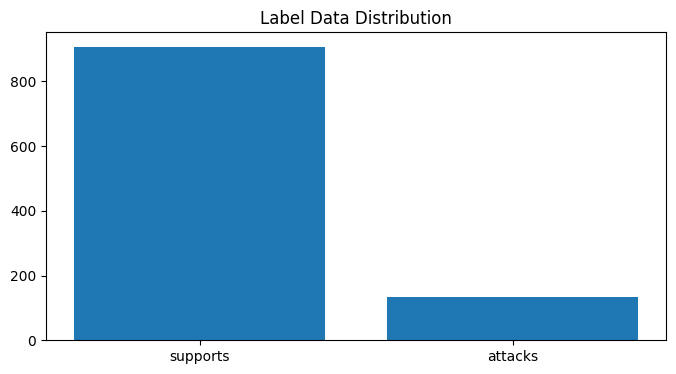

In [7]:
val_count = df.Label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title('Label Data Distribution')

In [8]:
# df['Text'] = df['Text'].apply(lambda x: x.lower())

# Balancing

In [9]:
from imblearn.over_sampling import SMOTEN, SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek
from collections import Counter

In [10]:
x = df['Text']
y = df['Label'].values

In [11]:
le = LabelEncoder()
y = le.fit_transform(y)
y = y.reshape(-1,1)

TFIDFVectorizer

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [ ]:
# df['text_id'] = df['Label'].factorize()[0]
# text_id_df = df[['Label', 'text_id']].drop_duplicates().sort_values('text_id')
# text_to_id = dict(text_id_df.values)
# id_to_text = dict(text_id_df[['text_id', 'Label']].values)
# df.head()

In [ ]:
# count_vect = CountVectorizer()
# tfidf_transformer = TfidfTransformer()

In [ ]:
# x_train_counts = count_vect.fit_transform(x_train)
# x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [ ]:
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# x_tfid = tfidf.fit_transform(x).toarray()

In [13]:
tfidf = TfidfVectorizer()
x_tfid = tfidf.fit_transform(x).toarray()

ADASYN

In [15]:
ada = ADASYN(sampling_strategy='minority', random_state=42, n_neighbors=5, n_jobs=-1)
x_ada, y_ada = ada.fit_resample(x_tfid, y)

In [16]:
print(f'After OverSampling: {Counter(y_ada)}')

After OverSampling: Counter({1: 906, 0: 900})


# Modelling Scikit-learn

In [17]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score

In [19]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),      #n_estimators=200, max_depth=3, random_state=0
    GaussianNB(),
    SVC(),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=3),
    XGBClassifier(),
]

target_models = ['RandomForestClassifier', 'GaussianNB', 'SVC', 'MultinomialNB', 'KNeighborsClassifier','XGBClassifier']
CV = 6
classification_reports = []
entries = []

for target_model in target_models:
    for model in models:
        model_name = model.__class__.__name__
        if model_name == target_model:
            accuracies = cross_val_score(model, x_ada, y_ada, scoring='accuracy', cv=CV)

            avg_accuracy = np.mean(accuracies)
            predictions = model.fit(x_ada, y_ada).predict(x_ada)

            report = classification_report(y_ada, predictions, output_dict=True)
            entries.append((model_name, avg_accuracy, report))

In [20]:
for model_name, avg_accuracy, report in entries:
    print(f"Classification Report for {model_name} - Average over all folds:\n")
    print(f"Average Accuracy: {avg_accuracy:.4f}\n")
    print(pd.DataFrame(report).transpose())
    print("\n")

Classification Report for RandomForestClassifier - Average over all folds:

Average Accuracy: 0.7425

              precision    recall  f1-score      support
0              0.950713  0.814444  0.877319   900.000000
1              0.838647  0.958057  0.894384   906.000000
accuracy       0.886489  0.886489  0.886489     0.886489
macro avg      0.894680  0.886251  0.885852  1806.000000
weighted avg   0.894494  0.886489  0.885880  1806.000000


Classification Report for GaussianNB - Average over all folds:

Average Accuracy: 0.8948

              precision    recall  f1-score      support
0              0.969828  1.000000  0.984683   900.000000
1              1.000000  0.969095  0.984305   906.000000
accuracy       0.984496  0.984496  0.984496     0.984496
macro avg      0.984914  0.984547  0.984494  1806.000000
weighted avg   0.984964  0.984496  0.984493  1806.000000


Classification Report for SVC - Average over all folds:

Average Accuracy: 0.9668

              precision    recall  f1

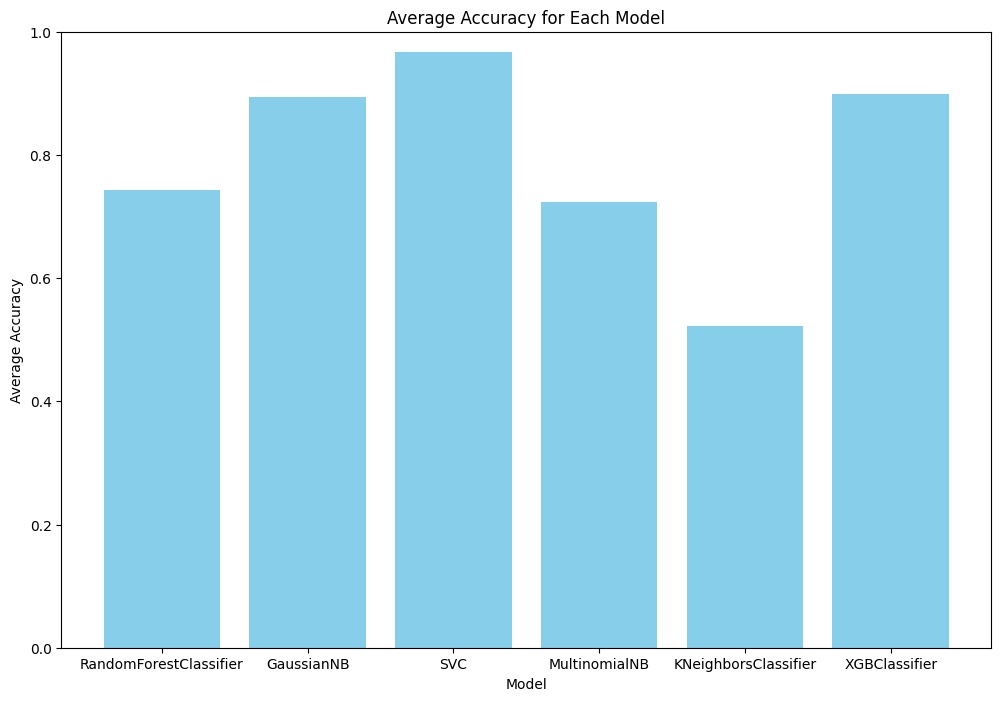

In [21]:
model_names, accuracies = zip(*[(entry[0], entry[1]) for entry in entries])

plt.figure(figsize=(12, 8))
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy for Each Model')
plt.ylim([0, 1])  # Assuming accuracy ranges between 0 and 1
plt.show()